# Pokemon Analysis

## <a id='top'></a>Table of Contents

1. [Web Scraping](#web-scrape)
    - [verify scrapability via robots.txt](#scrape?)
    - [scrape data](#scrape-data)
1. [EDA](#eda)
1. [ML Models](#ml)

-----**TO DELETE**-----
* Type prediction using Logistic Regression, Decision Trees, Random Forest, Support Vector Machines, K-Nearest Neighbors, Naive Bayes, Gradient Boosting
    * Use base stats
* Image recognition with Convolutional Neural Networks

In [1]:
# fundamental modules
import pandas as pd
import numpy as np

# web scraping modules
import requests
import bs4

# visual modules
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning modules
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


import re

%matplotlib inline

## <a id='web-scrape'></a>Web Scraping
[back to top](#top)

### <a id='scrape?'></a>Verify scrapability via robots.txt

In [2]:
def allowed_by_robots_txt(url):
    """
    Returns a boolean value representing if a url is allowed 
    to be scraped, according to the site's robots.txt
    ---
    url: string representing url to scrape
    """
    # Get robots.txt
    url_split = gen1_url.split("/")
    robots_txt_url = url_split[0] + '//' + url_split[2] + '/robots.txt'

    response = requests.get(robots_txt_url)
    response.raise_for_status()

    lines = response.text.split('\n')

    user_agent_allowed = True

    for line in lines:
        if line.lower().startswith('disallow'):
            # Check if the URL is disallowed
            disallowed_path = line.split(':', 1)[1].strip()
            if url.endswith(disallowed_path):
                return False

    # If no specific rule is found, the URL is allowed
    return True

In [3]:
gen1_url = "https://pokemondb.net/pokedex/stats/gen1"
gen2_url = "https://pokemondb.net/pokedex/stats/gen2"
gen3_url = "https://pokemondb.net/pokedex/stats/gen3"

gen1_allowed = allowed_by_robots_txt(gen1_url)
gen2_allowed = allowed_by_robots_txt(gen2_url)
gen3_allowed = allowed_by_robots_txt(gen3_url)

print(f'Gen 1 scrapable: {gen1_allowed}\nGen 2 scrapable: {gen2_allowed}\nGen 3 scrapable: {gen3_allowed}')

Gen 1 scrapable: True
Gen 2 scrapable: True
Gen 3 scrapable: True


### <a id='scrape-data'></a>Scrape Data

In [4]:
def get_pokedex(url):
    """
    Returns a DataFrame object that contains the Pokédex for the url to the specified generation.
    ---
    url: string representing url to scrape
    """
    # Make request to site
    response = requests.get(url)
    
    # Check to see if response was successful
    if response.status_code == 200:
        html_content = response.text
    else:
        raise Exception(f"Error: Unable to fetch content. Status code: {response.status_code}.")
        
    # create soup object and get only 'tr' tags
    soup = bs4.BeautifulSoup(html_content, features='lxml')
    soup = soup.find('div', class_='resp-scroll').find_all('tr')
    
    # get column data
    column_info = soup[0]
    column_info = column_info.find_all('th')
    
    # get data
    num, name, elements, total, hp, attack, defense, spatk, spdef, spd = [], [], [], [], [], [], [], [], [], []
    for pokemon in soup[1:]:
        num.append(pokemon.find_all('td')[0].text)
        name.append(pokemon.find_all('td')[1].text)
        elements.append(pokemon.find_all('td')[2].text)
        total.append(pokemon.find_all('td')[3].text)
        hp.append(pokemon.find_all('td')[4].text)
        attack.append(pokemon.find_all('td')[5].text)
        defense.append(pokemon.find_all('td')[6].text)
        spatk.append(pokemon.find_all('td')[7].text)
        spdef.append(pokemon.find_all('td')[8].text)
        spd.append(pokemon.find_all('td')[9].text)
    
    # combine column data and raw data to form DataFrame
    data = {column_info[0].text: num, 
            column_info[1].text: name, 
            column_info[2].text: elements, 
            column_info[3].text: total, 
            column_info[4].text: hp, 
            column_info[5].text: attack, 
            column_info[6].text: defense, 
            column_info[7].text: spatk, 
            column_info[8].text: spdef, 
            column_info[9].text: spd}
    return pd.DataFrame(data)

In [5]:
gen1 = get_pokedex(gen1_url)
gen2 = get_pokedex(gen2_url)
gen3 = get_pokedex(gen3_url)

In [6]:
gen1.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0001,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,0002,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,0003,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,0004,Charmander,Fire,309,39,52,43,60,50,65
4,0005,Charmeleon,Fire,405,58,64,58,80,65,80


In [7]:
gen2.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0152,Chikorita,Grass,318,45,49,65,49,65,45
1,0153,Bayleef,Grass,405,60,62,80,63,80,60
2,0154,Meganium,Grass,525,80,82,100,83,100,80
3,0155,Cyndaquil,Fire,309,39,52,43,60,50,65
4,0156,Quilava,Fire,405,58,64,58,80,65,80


In [8]:
gen3.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0252,Treecko,Grass,310,40,45,35,65,55,70
1,0253,Grovyle,Grass,405,50,65,45,85,65,95
2,0254,Sceptile,Grass,530,70,85,65,105,85,120
3,0255,Torchic,Fire,310,45,60,40,70,50,45
4,0256,Combusken,Fire Fighting,405,60,85,60,85,60,55


## <a id='eda'></a>EDA 
[back to top](#top)

In [9]:
df = pd.concat(objs=[gen1, gen2, gen3], axis=0, ignore_index=True)

In [10]:
df.head()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0001,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,0002,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,0003,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,0004,Charmander,Fire,309,39,52,43,60,50,65
4,0005,Charmeleon,Fire,405,58,64,58,80,65,80


In [11]:
df.tail()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
387,0385,Jirachi,Steel Psychic,600,100,100,100,100,100,100
388,0386,Deoxys Normal Forme,Psychic,600,50,150,50,150,50,150
389,0386,Deoxys Attack Forme,Psychic,600,50,180,20,180,20,150
390,0386,Deoxys Defense Forme,Psychic,600,50,70,160,70,160,90
391,0386,Deoxys Speed Forme,Psychic,600,50,95,90,95,90,180


In [12]:
df.shape[0]

392

This number states that there are 392 Pokémon registered in the Pokedéx between generations 1-3. However, the tail of the DataFrame lets us know that there are 386 unique number of Pokémon. 

In [13]:
df[df['#'].duplicated(keep=False)]

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
350,0351,Castform,Normal,420,70,70,70,70,70,70
351,0351,Castform Sunny Form,Fire,420,70,70,70,70,70,70
352,0351,Castform Rainy Form,Water,420,70,70,70,70,70,70
353,0351,Castform Snowy Form,Ice,420,70,70,70,70,70,70
388,0386,Deoxys Normal Forme,Psychic,600,50,150,50,150,50,150
389,0386,Deoxys Attack Forme,Psychic,600,50,180,20,180,20,150
390,0386,Deoxys Defense Forme,Psychic,600,50,70,160,70,160,90
391,0386,Deoxys Speed Forme,Psychic,600,50,95,90,95,90,180


To fix this duplicated data, I decided to keep only the first occurence.

In [14]:
df[df['#'].duplicated()]

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
351,0351,Castform Sunny Form,Fire,420,70,70,70,70,70,70
352,0351,Castform Rainy Form,Water,420,70,70,70,70,70,70
353,0351,Castform Snowy Form,Ice,420,70,70,70,70,70,70
389,0386,Deoxys Attack Forme,Psychic,600,50,180,20,180,20,150
390,0386,Deoxys Defense Forme,Psychic,600,50,70,160,70,160,90
391,0386,Deoxys Speed Forme,Psychic,600,50,95,90,95,90,180


In [15]:
# Remove duplicate values
df = (df
      .drop_duplicates(subset='#', keep='first', inplace=False)
      .reset_index(drop=True))
df.tail()

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
381,0382,Kyogre,Water,670,100,100,90,150,140,90
382,0383,Groudon,Ground,670,100,150,140,100,90,90
383,0384,Rayquaza,Dragon Flying,680,105,150,90,150,90,95
384,0385,Jirachi,Steel Psychic,600,100,100,100,100,100,100
385,0386,Deoxys Normal Forme,Psychic,600,50,150,50,150,50,150


In [16]:
# Check for missing values
df.isnull().sum()

#          0
Name       0
Type       0
Total      0
HP         0
Attack     0
Defense    0
Sp. Atk    0
Sp. Def    0
Speed      0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   #        386 non-null    object
 1   Name     386 non-null    object
 2   Type     386 non-null    object
 3   Total    386 non-null    object
 4   HP       386 non-null    object
 5   Attack   386 non-null    object
 6   Defense  386 non-null    object
 7   Sp. Atk  386 non-null    object
 8   Sp. Def  386 non-null    object
 9   Speed    386 non-null    object
dtypes: object(10)
memory usage: 30.3+ KB


Besides #, Name, and Type, every column should be quantitative discrete, not a dtype of object. Thus, these columns must be changed to dtype int32.

In [18]:
df = pd.concat([df.iloc[:, :3], 
                df.iloc[:, 3:].astype('int32')], 
               axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   #        386 non-null    object
 1   Name     386 non-null    object
 2   Type     386 non-null    object
 3   Total    386 non-null    int32 
 4   HP       386 non-null    int32 
 5   Attack   386 non-null    int32 
 6   Defense  386 non-null    int32 
 7   Sp. Atk  386 non-null    int32 
 8   Sp. Def  386 non-null    int32 
 9   Speed    386 non-null    int32 
dtypes: int32(7), object(3)
memory usage: 19.7+ KB


In [19]:
df.iloc[:, 3:].describe().T

,count,mean,std,min,25%,50%,75%,max
Total,386.0,406.152850,108.583130,180.0,314.00,410.0,490.0,680.0
HP,386.0,66.474093,28.239893,1.0,50.00,63.5,80.0,255.0
Attack,386.0,71.777202,28.496563,5.0,50.00,70.0,90.0,160.0
Defense,386.0,68.878238,30.619461,5.0,48.25,65.0,85.0,230.0
Sp. Atk,386.0,66.707254,27.674261,10.0,45.00,65.0,85.0,154.0
Sp. Def,386.0,67.839378,27.833552,20.0,50.00,65.0,83.0,230.0
Speed,386.0,64.476684,27.212883,5.0,45.00,64.0,85.0,160.0


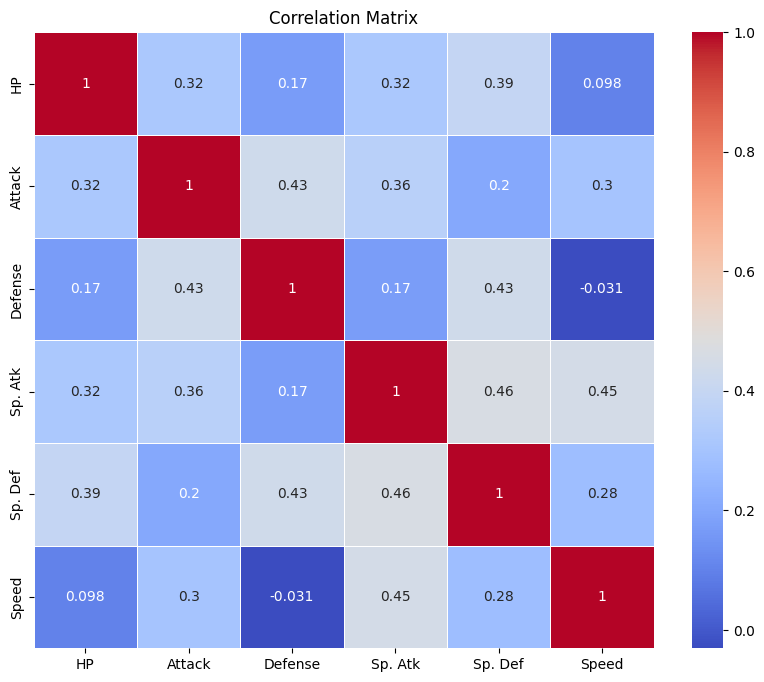

In [20]:
# Correlations between numerical features.
correlation_matrix = df.iloc[:, 4:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

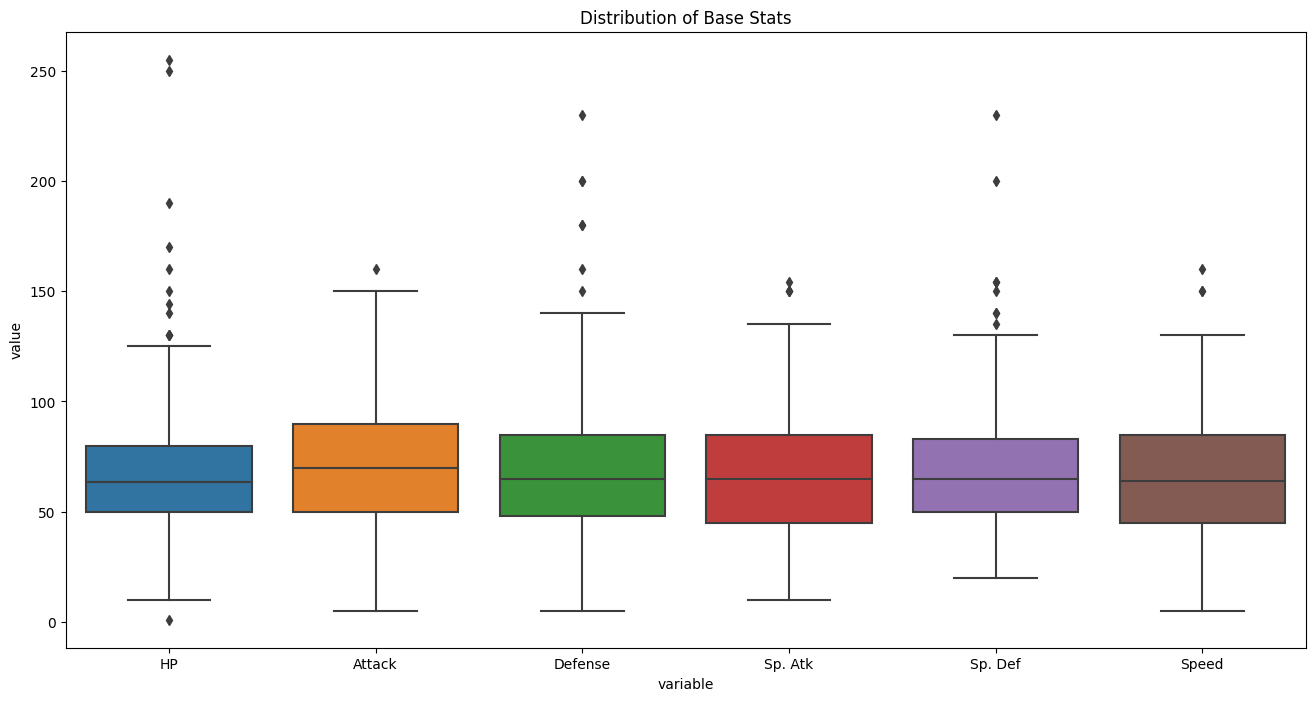

In [21]:
# Box plots of individual base stats.
plt.figure(figsize=(16, 8))
sns.boxplot(x='variable', y='value', data=pd.melt(df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]))
plt.title('Distribution of Base Stats')
plt.show()

Initially, I was planning on getting rid of all rows in which there were less than 5 occurences for each type. This would mean that most dual-types (Pokémon with both a primary and secondary type) would be deleted from the dataset. Thus, to ensure that too much data won't be deleted, I made sure that the integrity of the data wouldn't be too affected.

In [22]:
type_counts = df['Type'].value_counts()
print(type_counts.index[type_counts < 5])
print(len(type_counts.index[type_counts < 5]))

Index(['Dragon Flying', 'Dark ', 'Dragon ', 'Steel Psychic', 'Rock Water',
       'Water Flying', 'Psychic Fairy', 'Grass Flying', 'Water Psychic',
       'Normal Fairy', 'Poison Flying', 'Rock ', 'Ghost Poison', 'Water Ice',
       'Fire Flying', 'Ice Water', 'Ice ', 'Water Dark', 'Water Poison',
       'Water Grass', 'Grass Dark', 'Steel Rock', 'Psychic Flying',
       'Grass Psychic', 'Fighting Psychic', 'Dark Fire', 'Fire Fighting',
       'Ground Dragon', 'Fire Ground', 'Ground Rock', 'Rock Psychic',
       'Ground Psychic', 'Rock Grass', 'Rock Bug', 'Water Rock', 'Ice Ground',
       'Dragon Psychic', 'Ice Psychic', 'Electric Steel', 'Ice Flying',
       'Water Electric', 'Bug Steel', 'Water Fairy', 'Bug Grass',
       'Poison Ground', 'Steel Fairy', 'Steel ', 'Rock Flying',
       'Electric Flying', 'Water Fighting', 'Fairy Flying', 'Dark Flying',
       'Dark Ice', 'Fire Rock', 'Bug Ghost', 'Bug Ground', 'Grass Fighting',
       'Bug Water', 'Normal Psychic', 'Ground Flying', '

68 unique types is a mouthful of data to get rid of. From all of these types, there is one interesting thing to take note of - five of these types are mono-types: **Dark**, **Dragon**, **Rock**, **Ice**, **Steel**.

From pokemon.db:
* Dark and Steel types were not in the game until Generation 2.

Inferences from competitive Pokémon:
* Ice and Rock are both terrible defensive typings, however they are also exceptional offensive typings. This comes down to both of these types having numerous defensive weaknesses while on the other hand, having huge offensive capabilities. Thus, this can be seen as a risk vs. reward scenario. https://www.reddit.com/r/pokemon/comments/116j10i/comment/j98w691/?utm_source=share&utm_medium=web2x&context=3. Furthermore, even after 9 generations of Pokémon, there still aren't a lot of pure ice and rock types.
    * STAB moves! https://pokemondb.net/pokebase/243394/what-is-stab-and-what-does-it-stand-for
* Until Generation 9, Dragon types were one of the strongest types in the game, not because of how their typing, but because of their bloated base stats. In addition, Pokémon that had the Dragon typing were usually found in the later parts of the main story game, where it would make sense to have such bloated stats to go against the end boss of the game (typically the Elite Four). Because of their end-game nature, there simply won't be enough "new Pokémon" to encounter at this stage of the game.

In order to "clean" the data for a better model of prediction, I decided to get rid of secondary typing and only use the primary typing of Pokémon. After all, a type that only appears once goes either in the training or testing, and this isn't exactly the best way to create a predictive model.

In [23]:
df['Type'] = df['Type'].apply(lambda x: x.split(' ')[0] if len(x) > 1 else x)
df['Type'].value_counts()

Water       70
Normal      55
Bug         34
Grass       33
Fire        26
Psychic     23
Rock        21
Electric    19
Poison      18
Ground      17
Fighting    13
Ice         12
Steel       11
Dragon      10
Dark         9
Ghost        8
Fairy        7
Name: Type, dtype: int64

Hmm... That data still seems strange. Fairy types weren't introduced until [Generation 6](https://pokemondb.net/type). This means that either Pokémon were added or previous Pokémons' types changed.
* Hint: It's the latter.

Thankfully, there is [a list](https://bulbapedia.bulbagarden.net/wiki/Category:Pok%C3%A9mon_that_have_had_their_type_changed) that contains all Pokémon whose types have been changed. However, only the Pokémon that have had their primary type changed will be reverted back in this dataset.
- Clefable (Fairy -> Normal)
- Clefairy (Fairy -> Normal)
- Cleffa (Fairy -> Normal)
- Togekiss (Fairy -> Normal)
- Togepi (Fairy -> Normal)
- Togekiss (Fairy -> Normal)
- Granbull (Fairy -> Normal)
- Snubbull (Fairy -> Normal)

In [24]:
# regex patterns
clepattern = re.compile(r'^Clef')
togepattern = re.compile(r'^Toge')
patternbull = re.compile(r'bull$')

# replace 'Fairy' to 'Normal'
df.loc[df['Name'].str.contains(clepattern), 'Type'] = 'Normal'
df.loc[df['Name'].str.contains(togepattern), 'Type'] = 'Normal'
df.loc[df['Name'].str.contains(patternbull), 'Type'] = 'Normal'

In [25]:
df['Type'].value_counts()

Water       70
Normal      62
Bug         34
Grass       33
Fire        26
Psychic     23
Rock        21
Electric    19
Poison      18
Ground      17
Fighting    13
Ice         12
Steel       11
Dragon      10
Dark         9
Ghost        8
Name: Type, dtype: int64

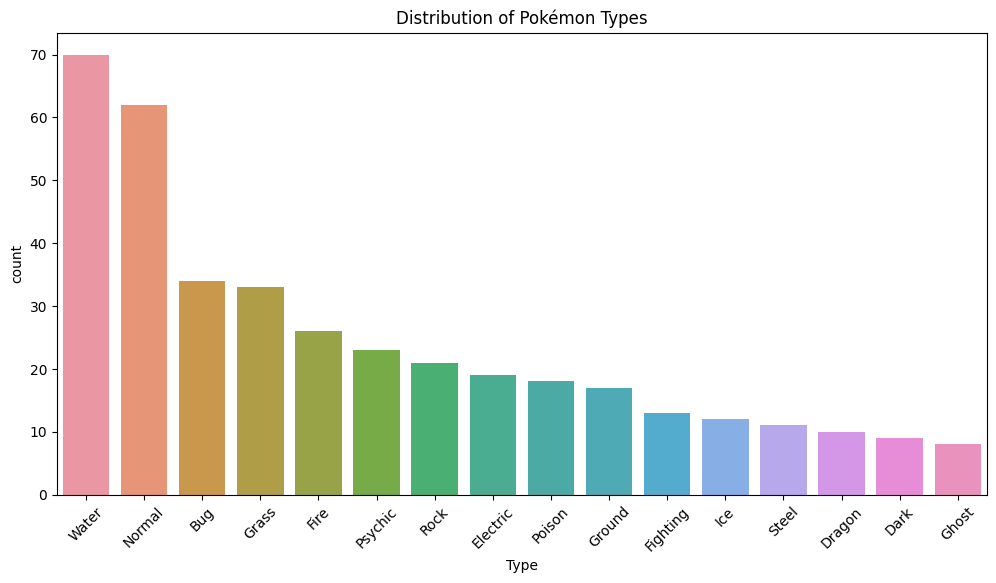

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Type', data=df, order=df['Type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Pokémon Types')
plt.show()

#### Interesting aggregates

In [27]:
# Shedinja is the only Pokémon with a total hitpoints of 1! This is because of his 
# signature ability - Wonder Guard - which makes him immune against damaging moves
# that are not super effective. https://pokemondb.net/ability/wonder-guard
df.loc[df['HP']==1]['Name']

291    Shedinja
Name: Name, dtype: object

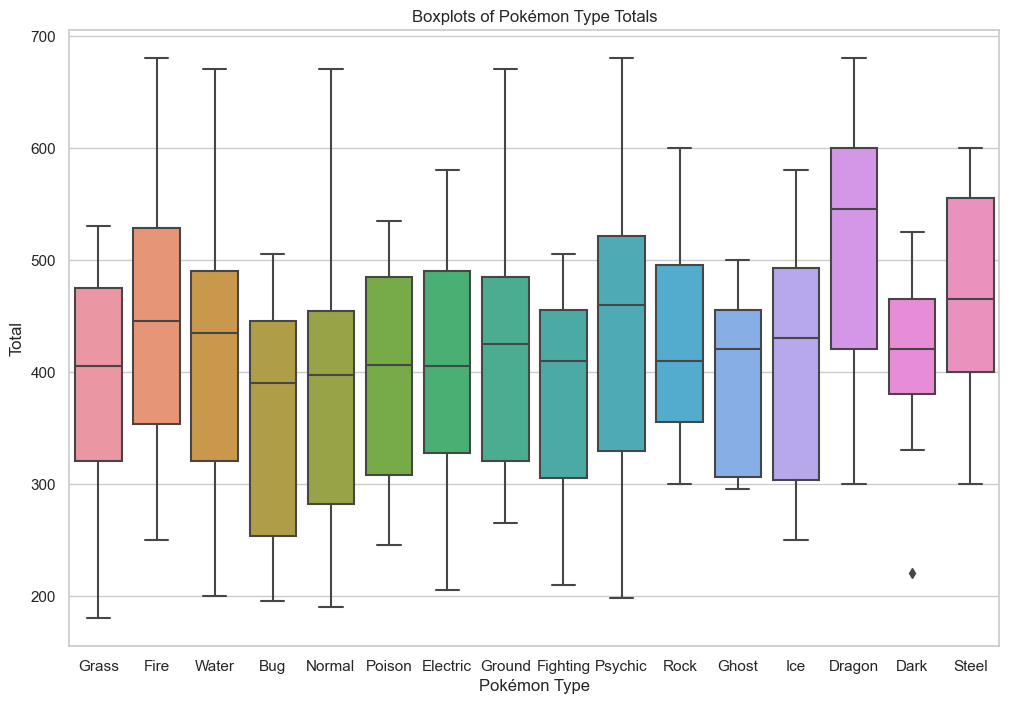

In [28]:
# Based on the boxplots, the Dragon type does seem to have the highest total aggregates out of all types in the game.

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Total', data=df, orient='v')
plt.title('Boxplots of Pokémon Type Totals')
plt.xlabel('Pokémon Type')
plt.ylabel('Total')
plt.show()

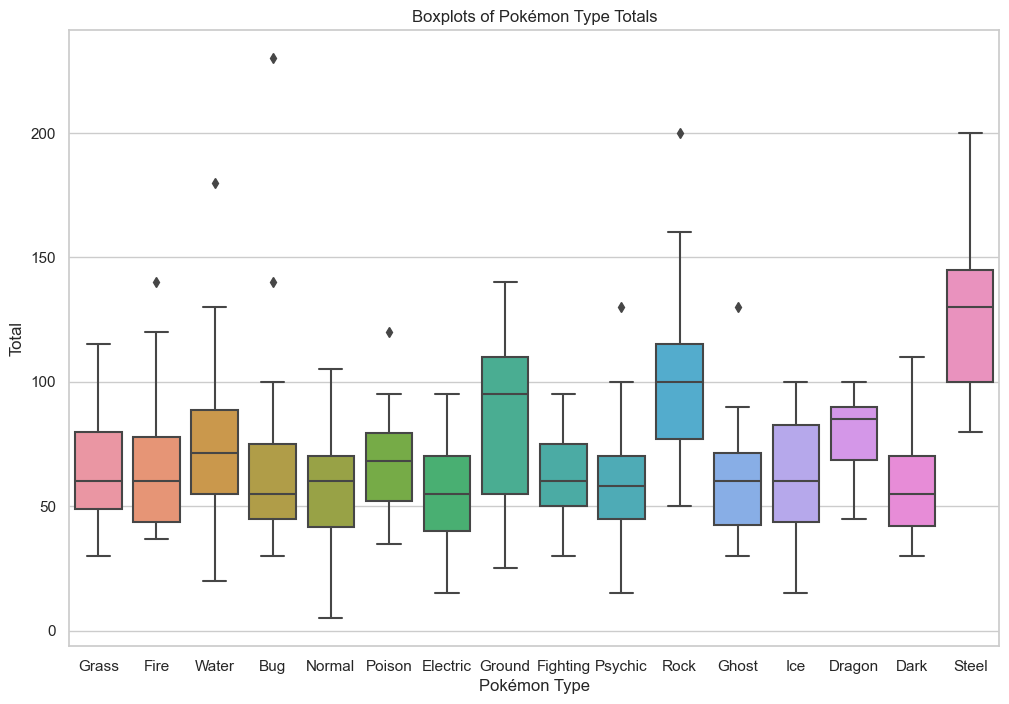

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
212,0213,Shuckle,Bug,505,20,10,230,10,230,5


In [29]:
# Steel seems to have the best defensive stats across every type, except for one exception in the Bug type: Shuckle.

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Defense', data=df, orient='v')
plt.title('Boxplots of Pokémon Type Totals')
plt.xlabel('Pokémon Type')
plt.ylabel('Total')
plt.show()
df.loc[df['Defense'] == df['Defense'].max()]

## <a id='ml'></a>ML Modeling
[back to top](#top)

### Preprocessing

In [30]:
# We won't be needing # and Name columns in predicting Type, so remove.
df = df.iloc[:, 1:]
df

,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,318,45,49,49,65,65,45
1,Ivysaur,Grass,405,60,62,63,80,80,60
2,Venusaur,Grass,525,80,82,83,100,100,80
3,Charmander,Fire,309,39,52,43,60,50,65
4,Charmeleon,Fire,405,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...
381,Kyogre,Water,670,100,100,90,150,140,90
382,Groudon,Ground,670,100,150,140,100,90,90
383,Rayquaza,Dragon,680,105,150,90,150,90,95
384,Jirachi,Steel,600,100,100,100,100,100,100


In [31]:
preproc = ColumnTransformer( 
    transformers=[
        ('categorical_col', OneHotEncoder(), ['Type']), 
        ('stdscaler', StandardScaler(), ['Total', 'Attack', 'Defense', 
                                         'Sp. Atk', 'Sp. Def', 'Speed']),
    ], 
    remainder='passthrough'
)

NameError: name 'StandardScaler' is not defined

In [ ]:
transformed_data = preproc.fit_transform(df[['Type']])
transformed_df = pd.DataFrame(transformed_data, columns=preproc.get_feature_names_out(['Type']))